<div style="nosxt-align:cennosr; font-size:26px; color:green;">ESTRATEGIA DE CRUCE DE  MEDIAS MOVILES EXPONENCIALES (EMA’s) </div>

Si no compartimos el conocimiento no sirve para nada. [Michio Kaku](https://www.younuestrobe.com/watch?v=6rDxlolYUQw)

**Descarga de cotizaciones.**  
Para obtener datos históricos de precios, puedes:

Descargarlos directamente desde las gestoras de los fondos.
Utilizar plataformas públicas como Yahoo Finance mediante la librería yfinance.
yfinance es una herramienta popular en análisis financiero que facilita el acceso a datos históricos considerados de dominio público. Sin embargo, estos datos pueden presentar pequeñas diferencias con respecto a las fuentes oficiales. Por ello, para decisiones críticas, siempre se recomienda contrastar la información con la documentación oficial de la gestora.

⚠️ **Precauciones.**
Este proyecto utiliza yfinance (con licencia bajo la [Apache License 2.0](https://www.apache.org/licenses/LICENSE-2.0).
), una interfaz para descargar datos financieros desde Yahoo Finance. Ten en cuenta lo siguiente:

Los datos descargados son exclusivamente para uso personal.
No está permitido redistribuirlos o venderlos.
Su uso en contextos educativos o sin ánimo de lucro suele ser aceptable, siempre que se cumplan estas condiciones.
Evita realizar peticiones excesivas o abusivas que puedan violar los términos de uso del servicio.



# Estrategia de cruce de Medias Móviles Exponenciales (EMA's)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from typing import Optional, Tuple, Dict, Any
import os
import yfinance as yf
import tkinter as tk
from tkinter import font

class ImportarCotizaciones:
    def __init__(self):
        self._data: Dict[str, pd.DataFrame] = {}
        self.all_value_closures: Optional[pd.DataFrame] = None
        self.value_closures: Optional[pd.DataFrame] = None
        self.all_benchmark_closures: Optional[pd.DataFrame] = None
        self.benchmark_close: Optional[pd.DataFrame] = None
        self.ticker: Optional[str] = None
        self.benchmark_ticker: Optional[str] = None
        self.start_date: Optional[str] = None
        self.end_date: Optional[str] = None
        self.directory_path: Optional[str] = None

    def solicitar_datos(self) -> Tuple[Optional[pd.DataFrame], Optional[pd.DataFrame], Optional[pd.DataFrame], Optional[pd.DataFrame]]:
        """Solicita los datos necesarios al usuario y devuelve los dataframes."""
        print("Selección del valor:")
        value_option = int(input("""
        ¿De dónde desea obtener el valor?
        1. Descargar de Yahoo Finance
        2. Importar de fichero CSV de Yahoo Finance
        3. Importar de fichero CSV de R4
        Seleccione una opción (1-3): """))

        if value_option == 1:
            self.ticker = self._get_input("Ingrese el ticker del valor: ")
            self.start_date = self._get_input("Ingrese la fecha de inicio (YYYY-MM-DD): ")
            self.end_date = self._get_input("Ingrese la fecha de fin (YYYY-MM-DD): ")
            self._fetch_data(self.ticker)
        elif value_option == 2:
            self.directory_path = self._get_input("Introduce la ruta para el valor (o presiona Enter para usar la misma): ", optional=True)
            if not self.directory_path:
                self.directory_path = os.getcwd()  # Usar el directorio actual si se presiona Enter
            value_archivo = self.listar_archivos()
            if value_archivo:
                self.ticker = os.path.splitext(value_archivo)[0]  # Usar el nombre del archivo como ticker (sin extensión)
                self.all_value_closures, self.value_closures = self.crear_data_frame_csv_yf(value_archivo)
                self._data[self.ticker] = self.all_value_closures
                self.start_date = str(self.all_value_closures.index.min().date()) if not self.all_value_closures.empty else None
                self.end_date = str(self.all_value_closures.index.max().date()) if not self.all_value_closures.empty else None
            else:
                print("No se seleccionó archivo para el valor.")
                return None, None, None, None
        elif value_option == 3:
            self.directory_path = self._get_input("Introduce la ruta para el valor (o presiona Enter para usar la misma): ", optional=True)
            if not self.directory_path:
                self.directory_path = os.getcwd()  # Usar el directorio actual si se presiona Enter
            value_archivo = self.listar_archivos()
            if value_archivo:
                self.ticker = os.path.splitext(value_archivo)[0]  # Usar el nombre del archivo como ticker (sin extensión)
                self.all_value_closures, self.value_closures = self.crear_data_frame_csv_r4(value_archivo)
                self._data[self.ticker] = self.all_value_closures
                self.start_date = str(self.all_value_closures.index.min().date()) if not self.all_value_closures.empty else None
                self.end_date = str(self.all_value_closures.index.max().date()) if not self.all_value_closures.empty else None
            else:
                print("No se seleccionó archivo para el valor.")
                return None, None, None, None
        else:
            print("Opción no válida para el valor.")
            return None, None, None, None

        # Preguntar por benchmark adicional
        quiere_benchmark = input("\n¿Desea añadir un benchmark? (s/n): ").lower()
        if quiere_benchmark == 's' or quiere_benchmark == 'si':
            self.solicitar_datos_benchmark()

        self.crear_data_frames()
        return self.all_value_closures, self.value_closures, self.all_benchmark_closures, self.benchmark_close

    def solicitar_datos_benchmark(self):
        """Solicita los datos del benchmark y los agrega al objeto."""
        print("\nSelección del benchmark adicional:")
        benchmark_option = int(input("""
        ¿De dónde desea obtener el benchmark?
        1. Descargar de Yahoo Finance
        2. Importar de fichero CSV de Yahoo Finance
        3. Importar de fichero CSV de R4
        Seleccione una opción (1-3): """))

        if benchmark_option == 1:
            self.benchmark_ticker = self._get_input("Ingrese el ticker del benchmark: ")
            if self.start_date and self.end_date:
                self._fetch_data(self.benchmark_ticker)
            else:
                print("Las fechas de inicio y fin del valor deben estar definidas primero.")
        elif benchmark_option == 2:
            benchmark_directory = self._get_input("Introduce la ruta para el benchmark (o presiona Enter para usar la misma): ", optional=True)
            if not benchmark_directory:
                benchmark_directory = self.directory_path

            self.directory_path = benchmark_directory
            benchmark_archivo = self.listar_archivos()

            if benchmark_archivo:
                self.benchmark_ticker = os.path.splitext(benchmark_archivo)[0]
                _, benchmark_close_data = self.crear_data_frame_csv_yf(benchmark_archivo)
                self._data[self.benchmark_ticker] = benchmark_close_data
            else:
                print("No se seleccionó archivo para el benchmark.")
        elif benchmark_option == 3:
            benchmark_directory = self._get_input("Introduce la ruta para el benchmark (o presiona Enter para usar la misma): ", optional=True)
            if not benchmark_directory:
                benchmark_directory = self.directory_path

            self.directory_path = benchmark_directory
            benchmark_archivo = self.listar_archivos()

            if benchmark_archivo:
                self.benchmark_ticker = os.path.splitext(benchmark_archivo)[0]
                _, benchmark_close_data = self.crear_data_frame_csv_r4(benchmark_archivo)
                self._data[self.benchmark_ticker] = benchmark_close_data
            else:
                print("No se seleccionó archivo para el benchmark.")
        else:
            print("Opción no válida para benchmark.")

    def _get_input(self, prompt: str, optional: bool = False) -> str:
        """Obtiene una entrada del usuario con validación."""
        while True:
            value = input(prompt).strip()
            if value or optional:
                return value
            print("Este campo es obligatorio. Por favor, ingréselo.")

    def _fetch_data(self, ticker: str) -> None:
        """Descarga datos históricos de precios para un ticker dado."""
        try:
            df = yf.download(ticker, start=self.start_date, end=self.end_date, auto_adjust=False, progress=False)
            df.index = pd.to_datetime(df.index)
            df.index.name = 'Date'
            self._data[ticker] = df
        except Exception as e:
            raise ValueError(f"No se pudieron descargar los datos para {ticker}: {e}")

    def format_date_index(self) -> None:
        """Formatea el índice de fechas de todos los DataFrames a 'YYYY-MM-DD'."""
        for df in self._data.values():
            if not df.empty:
                df.index = pd.to_datetime(df.index).strftime('%Y-%m-%d')
                df.index = pd.to_datetime(df.index)

    @property
    def combined_close_df(self) -> Optional[pd.DataFrame]:
        """Devuelve un DataFrame con los precios de cierre fusionados."""
        if not self._data or not self.ticker:
            return None

        df = self._data[self.ticker][['Close']].copy()
        df.columns = [f'Close_{self.ticker}']

        if self.benchmark_ticker and self.benchmark_ticker in self._data:
            benchmark_df = self._data[self.benchmark_ticker][['Close']]
            benchmark_df.columns = [f'Close_{self.benchmark_ticker}']
            df = pd.merge(df, benchmark_df, left_index=True, right_index=True)

        return df

    def crear_data_frames(self) -> None:
        """Crea y almacena los DataFrames necesarios."""
        if not self._data or not self.ticker:
            return

        self.format_date_index()

        # Seleccionar el nivel de etiqueta de columnas deseado para historical_closes
        for ticker in self._data.keys():
            if isinstance(self._data[ticker].columns, pd.MultiIndex):
                self._data[ticker].columns = self._data[ticker].columns.get_level_values('Price')

        self.all_value_closures = self._data[self.ticker]
        self.value_closures = self._data[self.ticker][['Close']]

        if self.benchmark_ticker and self.benchmark_ticker in self._data:
            self.all_benchmark_closures = self._data[self.benchmark_ticker]
            self.benchmark_close = self._data[self.benchmark_ticker][['Close']]
        else:
            self.all_benchmark_closures = None
            self.benchmark_close = None

    def get_historical_prices(self) -> Tuple[Dict[str, Any], Optional[pd.DataFrame], Optional[pd.DataFrame], Optional[pd.DataFrame], Optional[pd.DataFrame]]:
        """Obtiene y devuelve un diccionario con los datos y los DataFrames."""
        self.crear_data_frames()

        data_dict = {
            'ticker': self.ticker,
            'benchmark_ticker': self.benchmark_ticker,
            'start_date': self.start_date,
            'end_date': self.end_date,
            'all_value_closes': self.all_value_closures,
            'value_close': self.value_closures,
            'all_benchmark_closes': self.all_benchmark_closures,
            'benchmark_close': self.benchmark_close
        }

        return data_dict, self.all_value_closures, self.value_closures, self.all_benchmark_closures, self.benchmark_close

    def listar_archivos(self):
        """Lista los archivos CSV en el directorio y permite seleccionar uno."""
        files = [f for f in os.listdir(self.directory_path) if f.endswith('.csv')]
        print("Archivos CSV disponibles:")
        for i, file in enumerate(files):
            print(f"{i+1}. {file}")

        while True:
            try:
                choice = int(input("Selecciona un archivo (o 0 para salir): "))
                if choice == 0:
                    return None
                elif 1 <= choice <= len(files):
                    return files[choice-1]
                else:
                    print("Opción inválida. Intenta de nuevo.")
            except ValueError:
                print("Por favor, ingresa un número válido.")

    def crear_data_frame_csv_yf(self, file_name):
        """Crea un DataFrame a partir del archivo seleccionado de Yahoo Finance."""
        file_path = os.path.join(self.directory_path, file_name)
        df =  pd.read_csv(
            file_path,
            sep=",",  # Yahoo usa comas como separador
            parse_dates=True,
            index_col="Date"  # La columna de fecha en Yahoo se llama "Date"
        )
        # Convertir el índice a datetime y formatearlo
        df.index = pd.to_datetime(df.index)
        df.index.name = 'Date'
        df.index = pd.to_datetime(df.index).strftime('%Y-%m-%d')
        df.index = pd.to_datetime(df.index)

        # Crear copias de los DataFrames
        self.all_value_closures = df.copy()
        self.value_closures = self.all_value_closures[['Close']]

        # Devuelve los DataFrames
        return self.all_value_closures, self.value_closures

    def crear_data_frame_csv_r4(self, file_name):
        """Crea un DataFrame a partir del archivo seleccionado de R4."""
        file_path = os.path.join(self.directory_path, file_name)

        try:
            # Leer el archivo con separador de espacio en blanco y nombres de columna explícitos
            df = pd.read_csv(
                file_path,
                sep=r'\s+',  # Usar cualquier espacio en blanco como delimitador (r'\s+')
                names=['Date', 'Close'],  # Nombres explícitos de las columnas
                decimal=",",  # Usar la coma como separador decimal
                skiprows=1,  # Saltar la fila de encabezado
                engine='python' # Añadimos el motor de python para evitar un warning.
            )

            # Limpiar la comilla y convertir a datetime
            df['Date'] = df['Date'].str.replace("'", "")
            df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')  # Especificamos el formato y convertimos las fechas inválidas en NaT

        except KeyError as e:
            # Manejar columnas faltantes
            print(f"Error: Columnas faltantes en '{file_name}': {e}")
            print("Columnas esperadas: 'Date', 'Close'")
            return None  # O lanzar una excepción específica

        # Eliminar filas con fechas inválidas
        df = df.dropna(subset=['Date'])

        # Establecer la columna 'Date' como índice
        df.set_index('Date', inplace=True)

        # Crear copias de los DataFrames
        self.all_value_closures = df.copy()
        self.value_closures = self.all_value_closures[['Close']]

        # Devuelve los DataFrames
        return self.all_value_closures, self.value_closures

class EMAsStrategy:
    def __init__(self, all_value_closures, value_closures,all_benchmark_closures, benchmark_close,
                 ticker, benchmark_ticker,start_date, end_date, short_period, long_period, initial_capital, ventana_moda):
        """
        Inicializa la clase AnalisisCotizaciones con los datos de cotizaciones.

        Args:
            all_value_closures (Optional[pd.DataFrame]): DataFrame con todos los datos del valor.
            value_closures (Optional[pd.DataFrame]): DataFrame con solo los precios de cierre del valor.
            all_benchmark_closures (Optional[pd.DataFrame]): DataFrame con todos los datos del benchmark.
            benchmark_close (Optional[pd.DataFrame]): DataFrame con solo los precios de cierre del benchmark.
            ticker (Optional[str]): Ticker del valor.
            benchmark_ticker (Optional[str]): Ticker del benchmark.
            start_date (Optional[str]): Fecha de inicio del periodo analizado (YYYY-MM-DD).
            end_date (Optional[str]): Fecha de fin del periodo analizado (YYYY-MM-DD).
        """
        self.all_value_closures = all_value_closures
        self.value_closures = value_closures
        self.all_benchmark_closures = all_benchmark_closures
        self.benchmark_close = benchmark_close
        self.ticker = ticker
        self.benchmark_ticker = benchmark_ticker
        self.start_date = start_date
        self.end_date = end_date
        self.rendimientos_valor = self.calcular_rendimientos(self.value_closures)
        self.rendimientos_benchmark = self.calcular_rendimientos(self.benchmark_close)
        self.short_period = short_period
        self.long_period = long_period
        self.initial_capital = initial_capital
        self.ventana_moda = ventana_moda

    def calcular_rendimientos(self, dataframe: Optional[pd.DataFrame]) -> Optional[pd.Series]:
        """
        Calcula los rendimientos porcentuales de un DataFrame de precios de cierre.

        Args:
            dataframe (Optional[pd.DataFrame]): DataFrame con una columna de precios de cierre.

        Returns:
            Optional[pd.Series]: Serie con los rendimientos porcentuales, o None si el DataFrame es inválido.
        """
        if dataframe is not None and not dataframe.empty and 'Close' in dataframe.columns:
            return dataframe['Close'].pct_change().dropna()
        return None

    def obtener_rendimientos_valor(self) -> Optional[pd.Series]:
        """
        Obtiene los rendimientos del valor.

        Returns:
            Optional[pd.Series]: Serie con los rendimientos del valor.
        """
        return self.rendimientos_valor

    def obtener_rendimientos_benchmark(self) -> Optional[pd.Series]:
        """
        Obtiene los rendimientos del benchmark.

        Returns:
            Optional[pd.Series]: Serie con los rendimientos del benchmark.
        """
        return self.rendimientos_benchmark

    def calculate_EMAs(self):
        """
        Calcula las EMAs (Exponential Moving Averages) y la señal del cruce.
        """
        if self.value_closures.empty:
            raise ValueError("No se encontraron datos de cierre. Asegúrate de haber descargado las cotizaciones correctamente.")

        self.emas_df = self.value_closures.copy()
        self.emas_df['Market_log_returns'] = np.log(self.emas_df['Close']).diff()
        self.emas_df.loc[self.emas_df.index[0], 'Market_log_returns'] = np.nan
        self.emas_df['Signal'] = 0.0
        self.emas_df['EMA_short'] = self.emas_df['Close'].ewm(span=self.short_period, adjust=False).mean()
        self.emas_df['EMA_long'] = self.emas_df['Close'].ewm(span=self.long_period, adjust=False).mean()

        return self.emas_df

    def implement_ema_strategy(self):
        """
        Implementa la estrategia basada en el cruce de EMAs.
        """
        self.emas_df['Position'] = np.where(self.emas_df['EMA_short'] > self.emas_df['EMA_long'], 1.0, 0.0)
        self.emas_df['Buy_sell_signals'] = self.emas_df['Position'].diff()
        self.emas_entry_exit_dates = self.emas_df[self.emas_df['Buy_sell_signals'] != 0]

        return self.emas_entry_exit_dates, self.emas_df

    def calculate_market_strategy_returns(self, rfr=0):
        """
        Calcula los rendimientos del mercado y de la estrategia.
        """
        self.emas_df['Strategy_returns'] = self.emas_df['Position'].shift(1) * self.emas_df['Market_log_returns']
        self.emas_df['Market_cum_returns'] = (1 + self.emas_df['Market_log_returns']).cumprod()
        self.emas_df['Strategy_cum_returns'] = (1 + self.emas_df['Strategy_returns']).cumprod()

        market_annualized_returns = round((self.emas_df['Market_cum_returns'].iloc[-1] ** (252 / len(self.emas_df)) - 1) * 100, 2)
        strategy_annualized_returns = round((self.emas_df['Strategy_cum_returns'].iloc[-1] ** (252 / len(self.emas_df)) - 1) * 100, 2)
        strategy_volatility = self.emas_df['Strategy_returns'].std() * np.sqrt(252)
        strategy_sharpe = (strategy_annualized_returns - rfr) / strategy_volatility

        print(f"Total market return: {self.emas_df['Market_cum_returns'].iloc[-1]:.2f}")
        print(f"Total strategy return: {self.emas_df['Strategy_cum_returns'].iloc[-1]:.2f}")
        print('\nSTRATEGY RETURNS:\n'
              f"\tMarket annualized returns: {market_annualized_returns:.2f}%\n" +
              f"\tStrategy annualized returns: {strategy_annualized_returns:.2f}%\n" +
              f"\tVolatility: {strategy_volatility * 100:.2f}%\n" +
              f"\tSharpe Ratio: {strategy_sharpe:.2f}")

    def calculate_capital_evolution(self, entry_exit_dates=None):
        """
        Calcula la evolución del capital a lo largo del tiempo basado en la estrategia implementada.
        """
        if entry_exit_dates is None:
            entry_exit_dates = self.emas_entry_exit_dates

        entry_exit_dates = entry_exit_dates.reset_index()
        capital_evolution = entry_exit_dates.copy()
        capital_evolution.rename(columns={'index': 'Date'}, inplace=True)

        capital_evolution['Shares'] = 0.0
        capital_evolution['Remainder'] = float(self.initial_capital)
        capital_evolution['Buy&SellCapital'] = float(self.initial_capital)

        first_buy_price = None
        buy_hold_shares = 0

        for i, row in capital_evolution.iterrows():
            if row['Buy_sell_signals'] == 1:
                if first_buy_price is None:
                    first_buy_price = row['Close']
                    buy_hold_shares = int(capital_evolution.at[i, 'Remainder'] / row['Close'])
                buy_shares = int(capital_evolution.at[i, 'Remainder'] / row['Close'])
                capital_evolution.at[i, 'Shares'] = buy_shares
                capital_evolution.at[i, 'Remainder'] -= buy_shares * row['Close']
                capital_evolution.at[i, 'Buy&SellCapital'] = capital_evolution.at[i, 'Remainder'] + buy_shares * row['Close']
            elif row['Buy_sell_signals'] == -1:
                capital_evolution.at[i, 'Buy&SellCapital'] = capital_evolution.at[i-1, 'Remainder'] + capital_evolution.at[i-1, 'Shares'] * row['Close']
                capital_evolution.at[i, 'Remainder'] = 0
                capital_evolution.at[i, 'Shares'] = 0

            if i > 0:
                if row['Buy_sell_signals'] == 1:
                    shares_to_buy = int(capital_evolution.at[i-1, 'Buy&SellCapital'] // row['Close'])
                    if shares_to_buy > 0:
                        capital_evolution.at[i, 'Shares'] = shares_to_buy
                        capital_evolution.at[i, 'Remainder'] = capital_evolution.at[i-1, 'Buy&SellCapital'] - shares_to_buy * row['Close']
                        capital_evolution.at[i, 'Buy&SellCapital'] = capital_evolution.at[i, 'Remainder'] + shares_to_buy * row['Close']
                elif row['Buy_sell_signals'] == -1:
                    capital_evolution.at[i, 'Buy&SellCapital'] = capital_evolution.at[i-1, 'Remainder'] + capital_evolution.at[i-1, 'Shares'] * row['Close']
                    capital_evolution.at[i, 'Remainder'] = 0.00
                    capital_evolution.at[i, 'Shares'] = 0

        if first_buy_price is not None:
            capital_evolution['Buy&HoldCapital'] = buy_hold_shares * capital_evolution['Close']
        else:
            capital_evolution['Buy&HoldCapital'] = float('nan')

        self.capital_evolution = capital_evolution
        return self.capital_evolution

    def calculate_profit_and_trades(self):
        """
        Calcula el beneficio y registra las operaciones realizadas.
        """
        datos = self.emas_entry_exit_dates.copy()
        capital = 100000  # Capital inicial de 100k€
        position = 0
        trades = []

        for index, row in datos.iterrows():
            signal = row['Buy_sell_signals']
            close_price = row['Close']

            if signal == 1 and position == 0:
                position = capital / close_price
                capital = 0
                trades.append((index, 'Compra', close_price, capital, position))

            elif signal == -1 and position > 0:
                capital = position * close_price
                trades.append((index, 'Venta', close_price, capital, position))
                position = 0

        self.trades_df = pd.DataFrame(trades, columns=['Date', 'Operation', 'Close', 'Capital', 'Shares'])
        self.beneficio = capital - 100000
        return self.trades_df, self.beneficio

        # Gráficas
    def matplotlib_plot_emas_strategy(self):
        """
        Método para graficar la estrategia de cruce de medias móviles exponenciales (EMAs).
        """

        fig, ax1 = plt.subplots(figsize=(8, 4))

        # Graficar cierre, EMA corta y EMA larga (corregido)
        self.value_closures['Close'].plot(color='orange', lw=1.5, alpha=0.7, label='Precio')
        self.emas_df['EMA_short'].plot(color='blue', lw=1.5, alpha=0.7, label='EMA Corta')
        self.emas_df['EMA_long'].plot(color='green', lw=1.5, alpha=0.7, label='EMA Larga')

        # Marcar señales de venta
        sell_signals = self.emas_entry_exit_dates[self.emas_entry_exit_dates['Buy_sell_signals'] == -1]
        ax1.plot(sell_signals.index, sell_signals.Close, 'v', markersize=10, color='red', lw=1.5, label='Venta')

        # Marcar señales de compra
        buy_signals = self.emas_entry_exit_dates[self.emas_entry_exit_dates['Buy_sell_signals'] == 1]
        ax1.plot(buy_signals.index, buy_signals.Close, '^', markersize=10, color='black', lw=1.5, label='Compra')

        # Etiqueta y formato de ejes
        ax1.set_ylabel('Precio (€)', fontsize=9)
        ax1.set_xlabel('Fecha', fontsize=9)
        plt.xticks(rotation=45, fontsize=9)  # X-axis ticks y etiquetas
        plt.yticks(rotation=45, fontsize=9)  # Y-axis ticks y etiquetas

        # Título y leyenda
        plt.title(f'Estrategia de cruce de las EMAs de {self.short_period} y {self.long_period}', fontsize=10)
        plt.legend(loc='upper left', prop={'size': 9})  # Leyenda con tamaño de fuente 9

        plt.show()

    def matplotlib_plot_emas_returns(self):
        """
        Método para graficar los rendimientos acumulados del mercado y la estrategia.
        """

        # Gráfica con los rendimientos acumulados
        self.emas_df[['Market_log_returns', 'Strategy_returns']].cumsum().apply(np.exp).plot(figsize=(10, 6), lw=1.5)

        # Etiqueta y formato del eje y
        plt.ylabel('Rendimiento Acumulado', fontsize=9)
        plt.xticks(rotation=45, fontsize=9)  # Rotar y ajustar tamaño de etiquetas x

        # Título con tamaño 10
        plt.title("Rendimientos Acumulados del Mercado y la Estrategia", fontsize=10)

        # Ajustar tamaño de fuente de la leyenda (requiere código de Matplotlib)
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles, labels, title="Leyenda", loc='upper left', prop={'size': 9})  # Leyenda con tamaño 9

        plt.show()

    def plotly_plot_emas_strategy(self):
        """
        Método para graficar la estrategia de cruce de medias móviles exponenciales (EMAs) usando Plotly.
        """

        # Crear traces para cada línea
        trace_close = go.Scatter(x=self.value_closures.index, y=self.value_closures['Close'], mode='lines', name='Precio', line=dict(color='orange', width=1.5))
        trace_short_ema = go.Scatter(x=self.emas_df.index, y=self.emas_df['EMA_short'], mode='lines', name='EMA Corta', line=dict(color='blue', width=1.5))
        trace_long_ema = go.Scatter(x=self.emas_df.index, y=self.emas_df['EMA_long'], mode='lines', name='EMA Larga', line=dict(color='green', width=1.5))

        # Crear traces para señales de compra y venta
        sell_signals = self.emas_entry_exit_dates[self.emas_entry_exit_dates['Buy_sell_signals'] == -1]
        trace_sell_signals = go.Scatter(x=sell_signals.index, y=sell_signals['Close'], mode='markers', name='Venta', marker=dict(symbol='triangle-down', size=10, color='red', line=dict(width=1.5)))

        buy_signals = self.emas_entry_exit_dates[self.emas_entry_exit_dates['Buy_sell_signals'] == 1]
        trace_buy_signals = go.Scatter(x=buy_signals.index, y=buy_signals['Close'], mode='markers', name='Compra', marker=dict(symbol='triangle-up', size=10, color='black', line=dict(width=1.5)))

        # Crear el layout
        layout = go.Layout(
          title=f'Estrategia de cruce de las EMAs de {self.short_period} y {self.long_period}',
          xaxis=dict(title='Fecha', tickfont=dict(size=9), tickangle=45),
          yaxis=dict(title='Precio (€)', tickfont=dict(size=9)),
          legend=dict(x=0.02, y=0.98, bgcolor='rgba(255, 255, 255, 0.5)', bordercolor='rgba(0, 0, 0, 0.5)', font=dict(size=9))
        )

        # Crear la figura y mostrarla
        fig = go.Figure(data=[trace_close, trace_short_ema, trace_long_ema, trace_sell_signals, trace_buy_signals], layout=layout)
        fig.show()


    def plotly_plot_emas_returns(self):
        """
        Método para graficar los rendimientos acumulados del mercado y la estrategia usando Plotly.
        """

        # Calcular los rendimientos acumulados
        cumulative_returns = self.emas_df[['Market_log_returns', 'Strategy_returns']].cumsum().apply(np.exp)

        # Crear traces para cada rendimiento
        trace_market = go.Scatter(x=cumulative_returns.index, y=cumulative_returns['Market_log_returns'], mode='lines', name='Rendimientos Mercado', line=dict(color='gray', width=1.5))
        trace_strategy = go.Scatter(x=cumulative_returns.index, y=cumulative_returns['Strategy_returns'], mode='lines', name='Rendimientos Estrategia', line=dict(color='purple', width=1.5))

        # Crear el layout
        layout = go.Layout(
            title="Rendimientos Acumulados del Mercado y la Estrategia",
            xaxis_title="Fecha",
            yaxis_title="Rendimiento Acumulado",
            legend=dict(x=0.01, y=0.99)
        )

        # Crear la figura y mostrarla
        fig = go.Figure(data=[trace_market, trace_strategy], layout=layout)
        fig.show()

    def imprimir_advertencia(self):
        """
        Muestra una advertencia personalizada con tamaño de fuente ajustable.
        """

        # Crear una ventana modal personalizada
        ventana_advertencia = tk.Toplevel()
        ventana_advertencia.title("Advertencia")

        # Crear un label con el texto de la advertencia y el tamaño de fuente deseado
        mensaje = """
        NOTA DE ADVERTENCIAS:

        Este notebook se proporciona únicamente con fines educativos e informativos.
        No se debe considerar asesoramiento legal o financiero.
        No se ofrece ninguna garantía u otra promesa en cuanto a los resultados que se pueden obtener al usar su contenido.
        En la medida máxima permitida por la ley, se nos exime de toda responsabilidad en caso de que cualquier información, comentario,
        análisis, opinión, consejo y / o recomendación se muestre inexacta, incompleta o poco confiable, o resulte en una inversión u otra pérdida.
        Se advierte que el rendimiento pasado no es un indicador confiable de resultados futuros.
        Recuerde que ninguna estrategia de trading es infalible, y siempre existe un riesgo asociado al operar en los mercados financieros.
        Es esencial gestionar adecuadamente el riesgo y utilizar la estrategia junto con una gestión de capital adecuada.
        Además, es recomendable consultar con profesionales financieros o analistas antes de tomar decisiones de trading importantes.
        """

        # Crear una fuente personalizada con tamaño 8
        fuente_pequena = font.Font(family="Arial", size=9)

        # Crear un label con la fuente personalizada
        label_advertencia = tk.Label(ventana_advertencia, text=mensaje, font=fuente_pequena, justify=tk.LEFT)
        label_advertencia.pack(padx=10, pady=10)

        # Botón para cerrar la ventana
        boton_cerrar = tk.Button(ventana_advertencia, text="Aceptar", command=ventana_advertencia.destroy)
        boton_cerrar.pack()

        # Centrar la ventana
        ventana_advertencia.update_idletasks()
        width = ventana_advertencia.winfo_width()
        height = ventana_advertencia.winfo_height()
        x = (ventana_advertencia.winfo_screenwidth() // 2) - (width // 2)
        y = (ventana_advertencia.winfo_screenheight() // 2) - (height // 2)
        ventana_advertencia.geometry("{}x{}+{}+{}".format(width, height, x, y))

        ventana_advertencia.mainloop()

    def run_strategy(self):
        self.imprimir_advertencia()
        self.calculate_EMAs()
        self.implement_ema_strategy()
        self.calculate_market_strategy_returns(rfr= 0)
        self.calculate_profit_and_trades()
        print('\n')
        self.calculate_capital_evolution()
        print('\n')
        self.matplotlib_plot_emas_strategy()
        self.matplotlib_plot_emas_returns()
        self.plotly_plot_emas_strategy()
        self.plotly_plot_emas_returns()

In [ ]:
# Ejemplo de uso
def InvocarImportarCotizaciones():
    importador = ImportarCotizaciones()
    all_value_closures, value_closures, all_benchmark_closures, benchmark_close = importador.solicitar_datos()
    # ···solicitar períodos EMAs, capital inicial y ventana moda
    ticker = importador.ticker
    benchmark_ticker = importador.benchmark_ticker
    start_date = importador.start_date
    end_date = importador.end_date

    # Solicitar al usuario los períodos para las EMAs
    while True:
        try:
            short_period_str = input("Introduce el período corto para la EMA (entero positivo): ")
            short_period = int(short_period_str)
            if short_period <= 0:
                raise ValueError
            break
        except ValueError:
            print("Por favor, introduce un número entero positivo válido para el período corto.")

    while True:
        try:
            long_period_str = input("Introduce el período largo para la EMA (entero positivo y mayor que el período corto): ")
            long_period = int(long_period_str)
            if long_period <= short_period or long_period <= 0:
                raise ValueError
            break
        except ValueError:
            print(f"Por favor, introduce un número entero positivo válido para el período largo, que sea mayor que {short_period}.")

    # Solicitar al usuario el capital inicial
    while True:
        try:
            initial_capital_str = input("Introduce el capital inicial (número positivo): ")
            initial_capital = float(initial_capital_str)
            if initial_capital <= 0:
                raise ValueError
            break
        except ValueError:
            print("Por favor, introduce un número positivo válido para el capital inicial.")

    # Solicitar al usuario la ventana de la moda
    while True:
        try:
            ventana_moda_str = input("Introduce la ventana para el cálculo de la moda (entero positivo): ")
            ventana_moda = int(ventana_moda_str)
            if ventana_moda <= 0:
                raise ValueError
            break
        except ValueError:
            print("Por favor, introduce un número entero positivo válido para la ventana de la moda.")

    # Instanciación y ejecución de la estrategia
    cruce_emas = EMAsStrategy(all_value_closures, value_closures,all_benchmark_closures, benchmark_close,
                             ticker, benchmark_ticker,start_date, end_date, short_period, long_period, initial_capital, ventana_moda)
    cruce_emas.imprimir_advertencia()
    cruce_emas.calculate_EMAs()
    cruce_emas.implement_ema_strategy()
    cruce_emas.calculate_market_strategy_returns(rfr= 0)
    cruce_emas.calculate_profit_and_trades()
    print('\n')
    cruce_emas.calculate_capital_evolution()
    print('\n')
    cruce_emas.matplotlib_plot_emas_strategy()
    cruce_emas.matplotlib_plot_emas_returns()

    print ('\nEvolución del capital invertido\n')
    print(cruce_emas.capital_evolution[['Date', 'Close', 'Position',  'Buy_sell_signals', 'Shares', 'Remainder', 'Buy&SellCapital', 'Buy&HoldCapital']].to_string())

## Tendencia Alcista Reciente (aprox. principios de 2020 - finales de 2024):

    EMA Corta: Similar a la primera tendencia alcista, períodos cortos para seguir el impulso. Podrías probar con EMA de 20 o 30 períodos.
    
    EMA Larga: Períodos intermedios para confirmar la tendencia reciente. Podrías probar con EMA de 50 o 80 períodos.
    
    Razón: Analizar si la estrategia se ha mantenido efectiva en la tendencia alcista más reciente es crucial.

### Utilizando EMA's de 20 y 50 períodos.

Selección del valor:



        ¿De dónde desea obtener el valor?
        1. Descargar de Yahoo Finance
        2. Importar de fichero CSV de Yahoo Finance
        3. Importar de fichero CSV de R4
        Seleccione una opción (1-3):  1
Ingrese el ticker del valor:  ^IBEX
Ingrese la fecha de inicio (YYYY-MM-DD):  2020-01-04
Ingrese la fecha de fin (YYYY-MM-DD):  2024-12-30

¿Desea añadir un benchmark? (s/n):  n
Introduce el período corto para la EMA (entero positivo):  20
Introduce el período largo para la EMA (entero positivo y mayor que el período corto):  50
Introduce el capital inicial (número positivo):  100000
Introduce la ventana para el cálculo de la moda (entero positivo):  20


Total market return: 1.07
Total strategy return: 0.77

STRATEGY RETURNS:
	Market annualized returns: 1.41%
	Strategy annualized returns: -5.11%
	Volatility: 12.75%
	Sharpe Ratio: -40.07






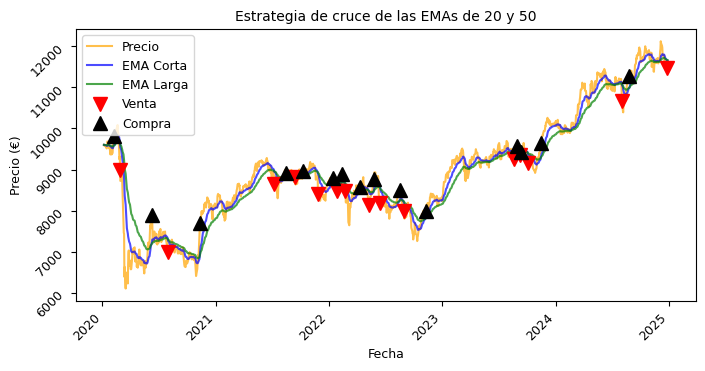

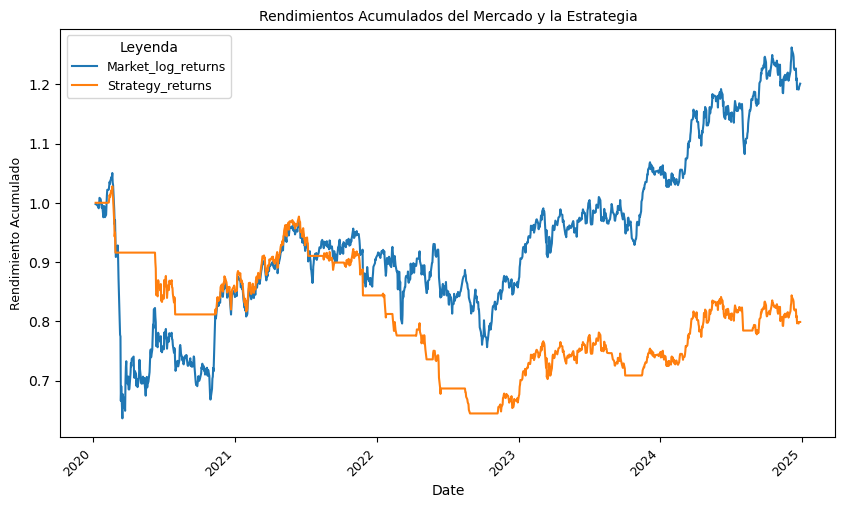


Evolución del capital invertido

Price       Date         Close  Position  Buy_sell_signals  Shares      Remainder  Buy&SellCapital  Buy&HoldCapital
0     2020-01-06   9600.900391       0.0               NaN     0.0  100000.000000    100000.000000     96009.003906
1     2020-02-07   9811.000000       1.0               1.0    10.0    1890.000000    100000.000000     98110.000000
2     2020-02-27   8985.900391       0.0              -1.0     0.0       0.000000     91749.003906     89859.003906
3     2020-06-08   7896.100098       1.0               1.0    11.0    4891.902832     91749.003906     78961.000977
4     2020-07-30   6996.600098       0.0              -1.0     0.0       0.000000     81854.503906     69966.000977
5     2020-11-10   7711.399902       1.0               1.0    10.0    4740.504883     81854.503906     77113.999023
6     2021-07-08   8650.099609       0.0              -1.0     0.0       0.000000     91241.500977     86500.996094
7     2021-08-16   8926.599609       1

In [ ]:
InvocarImportarCotizaciones()

### Utilizando  EMA's de 30 y 80 períodos.

Selección del valor:



        ¿De dónde desea obtener el valor?
        1. Descargar de Yahoo Finance
        2. Importar de fichero CSV de Yahoo Finance
        3. Importar de fichero CSV de R4
        Seleccione una opción (1-3):  1
Ingrese el ticker del valor:  ^IBEX
Ingrese la fecha de inicio (YYYY-MM-DD):  2020-01-04
Ingrese la fecha de fin (YYYY-MM-DD):  2024-12-30

¿Desea añadir un benchmark? (s/n):  n
Introduce el período corto para la EMA (entero positivo):  30
Introduce el período largo para la EMA (entero positivo y mayor que el período corto):  80
Introduce el capital inicial (número positivo):  100000
Introduce la ventana para el cálculo de la moda (entero positivo):  20


Total market return: 1.07
Total strategy return: 0.95

STRATEGY RETURNS:
	Market annualized returns: 1.41%
	Strategy annualized returns: -1.09%
	Volatility: 11.94%
	Sharpe Ratio: -9.13






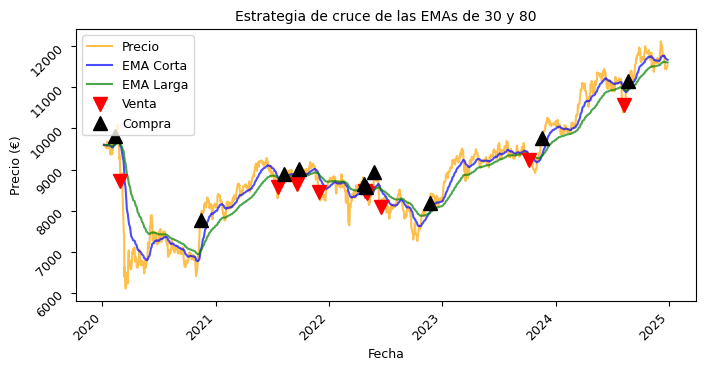

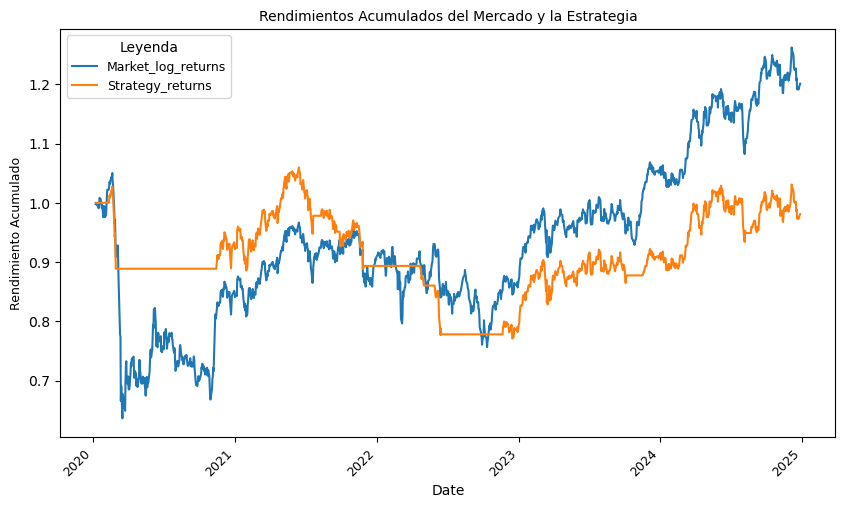


Evolución del capital invertido

Price       Date         Close  Position  Buy_sell_signals  Shares      Remainder  Buy&SellCapital  Buy&HoldCapital
0     2020-01-06   9600.900391       0.0               NaN     0.0  100000.000000    100000.000000     96009.003906
1     2020-02-10   9816.000000       1.0               1.0    10.0    1840.000000    100000.000000     98160.000000
2     2020-02-28   8723.200195       0.0              -1.0     0.0       0.000000     89072.001953     87232.001953
3     2020-11-13   7783.700195       1.0               1.0    11.0    3451.299805     89072.001953     77837.001953
4     2021-07-21   8567.000000       0.0              -1.0     0.0       0.000000     97688.299805     85670.000000
5     2021-08-10   8899.000000       1.0               1.0    10.0    8698.299805     97688.299805     88990.000000
6     2021-09-20   8655.400391       0.0              -1.0     0.0       0.000000     95252.303711     86554.003906
7     2021-09-27   9002.900391       1

In [ ]:
InvocarImportarCotizaciones()

## Para Tendencia Alcista Reciente (ej. 2020-2024), se podrían probar

    Combinaciones más largas (para evitar whipsaws en un mercado potencialmente volátil):
    
        50 y 150: Para enfocarse en la tendencia principal a medio-largo plazo.
        
        80 y 180: Otra opción para un enfoque más conservador.

### Utilizando EMA's de 50 y 150 períodos.

Selección del valor:



        ¿De dónde desea obtener el valor?
        1. Descargar de Yahoo Finance
        2. Importar de fichero CSV de Yahoo Finance
        3. Importar de fichero CSV de R4
        Seleccione una opción (1-3):  1
Ingrese el ticker del valor:  ^IBEX
Ingrese la fecha de inicio (YYYY-MM-DD):  2020-01-04
Ingrese la fecha de fin (YYYY-MM-DD):  2024-12-30

¿Desea añadir un benchmark? (s/n):  n
Introduce el período corto para la EMA (entero positivo):  50
Introduce el período largo para la EMA (entero positivo y mayor que el período corto):  150
Introduce el capital inicial (número positivo):  100000
Introduce la ventana para el cálculo de la moda (entero positivo):  20


Total market return: 1.07
Total strategy return: 1.15

STRATEGY RETURNS:
	Market annualized returns: 1.41%
	Strategy annualized returns: 2.88%
	Volatility: 12.06%
	Sharpe Ratio: 23.87






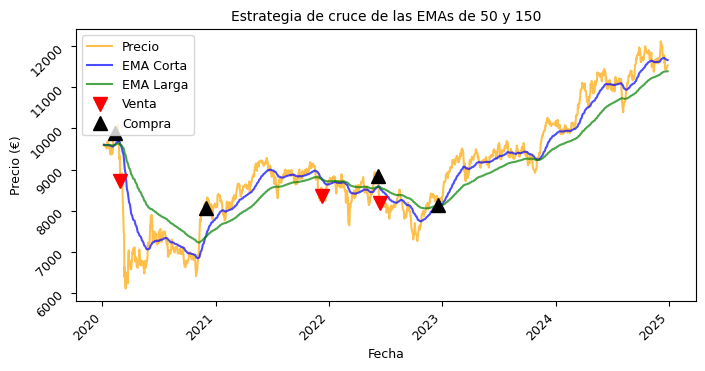

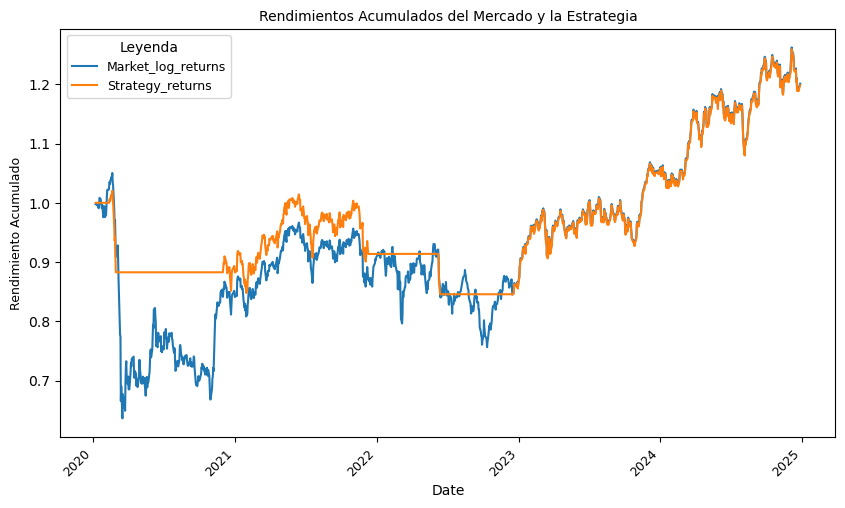


Evolución del capital invertido

Price       Date        Close  Position  Buy_sell_signals  Shares      Remainder  Buy&SellCapital  Buy&HoldCapital
0     2020-01-06  9600.900391       0.0               NaN     0.0  100000.000000    100000.000000     96009.003906
1     2020-02-11  9882.599609       1.0               1.0    10.0    1174.003906    100000.000000     98825.996094
2     2020-02-28  8723.200195       0.0              -1.0     0.0       0.000000     88406.005859     87232.001953
3     2020-11-30  8076.899902       1.0               1.0    10.0    7637.006836     88406.005859     80768.999023
4     2021-12-10  8360.200195       0.0              -1.0     0.0       0.000000     91239.008789     83602.001953
5     2022-06-07  8841.599609       1.0               1.0    10.0    2823.012695     91239.008789     88415.996094
6     2022-06-13  8183.299805       0.0              -1.0     0.0       0.000000     84656.010742     81832.998047
7     2022-12-19  8136.799805       1.0       

In [ ]:
InvocarImportarCotizaciones()

### Utilizando EMA's de 80 y 180 períodos.

Selección del valor:



        ¿De dónde desea obtener el valor?
        1. Descargar de Yahoo Finance
        2. Importar de fichero CSV de Yahoo Finance
        3. Importar de fichero CSV de R4
        Seleccione una opción (1-3):  1
Ingrese el ticker del valor:  ^IBEX
Ingrese la fecha de inicio (YYYY-MM-DD):  2020-01-04
Ingrese la fecha de fin (YYYY-MM-DD):  2024-12-30

¿Desea añadir un benchmark? (s/n):  n
Introduce el período corto para la EMA (entero positivo):  80
Introduce el período largo para la EMA (entero positivo y mayor que el período corto):  180
Introduce el capital inicial (número positivo):  100000
Introduce la ventana para el cálculo de la moda (entero positivo):  20


Total market return: 1.07
Total strategy return: 1.14

STRATEGY RETURNS:
	Market annualized returns: 1.41%
	Strategy annualized returns: 2.69%
	Volatility: 12.08%
	Sharpe Ratio: 22.27






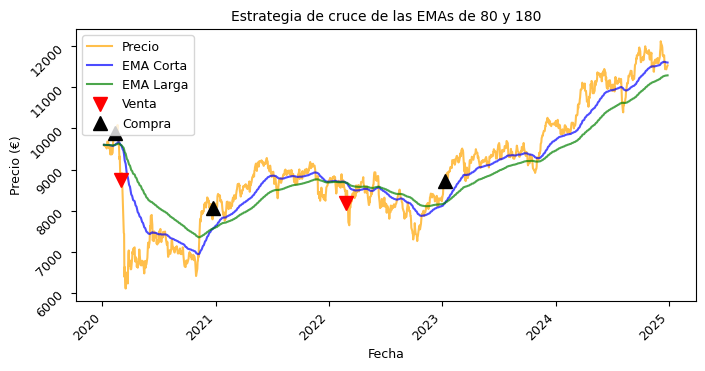

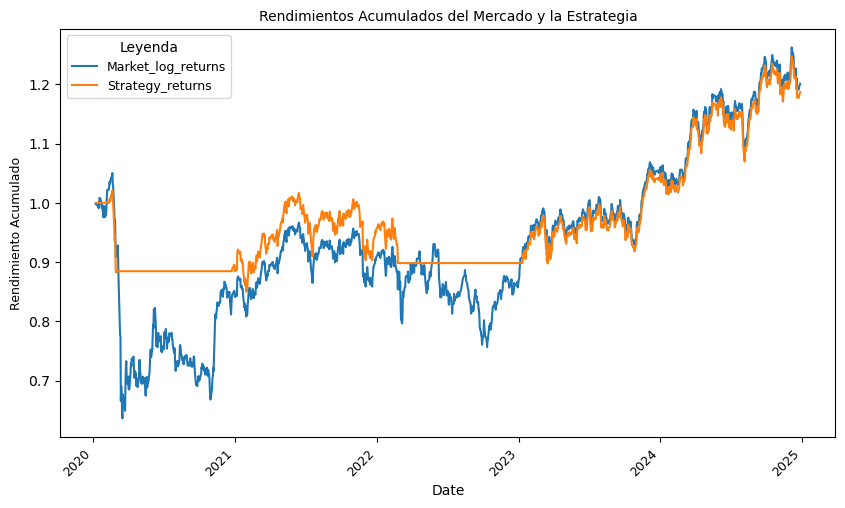


Evolución del capital invertido

Price       Date        Close  Position  Buy_sell_signals  Shares      Remainder  Buy&SellCapital  Buy&HoldCapital
0     2020-01-06  9600.900391       0.0               NaN     0.0  100000.000000    100000.000000     96009.003906
1     2020-02-11  9882.599609       1.0               1.0    10.0    1174.003906    100000.000000     98825.996094
2     2020-03-02  8741.500000       0.0              -1.0     0.0       0.000000     88589.003906     87415.000000
3     2020-12-23  8073.600098       1.0               1.0    10.0    7853.002930     88589.003906     80736.000977
4     2022-02-24  8198.500000       0.0              -1.0     0.0       0.000000     89838.002930     81985.000000
5     2023-01-11  8726.299805       1.0               1.0    10.0    2575.004883     89838.002930     87262.998047


In [ ]:
InvocarImportarCotizaciones()

# Nota de advertencias.
<font color='blue'>
Este note book se proporciona únicamente con fines educativos e informativos. No se debe considerar asesoramiento legal o financiero. No se ofrece ninguna garantía u otra promesa en cuanto a los resultados que se pueden obtener al usar su contenido.
    
En la medida máxima permitida por la ley, se nos exime de toda responsabilidad en caso de que cualquier información, comentario, análisis, opinión, consejo y / o recomendación se muestre inexacta, incompleta o poco confiable, o resulte en una inversión u otra pérdida. Se advierte que el rendimiento pasado no es un indicador confiable de resultados futuros.
    
Recuerde que ninguna estrategia de trading es infalible, y siempre existe un riesgo asociado al operar en los mercados financieros. Es esencial gestionar adecuadamente el riesgo y utilizar la estrategia junto con una gestión de capital adecuada. Además, es recomendable consultar con profesionales financieros o analistas antes de tomar decisiones de trading importantes.
    </font>